In [11]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import ttest_ind
from datetime import timedelta
import matplotlib.patches as mpatches
# import sklearn

## Read data 
    
    Parse the dates

In [3]:
date_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%y')
medication_df_raw = pd.read_csv('./medication.csv', parse_dates=['date'], date_parser=date_parser)
user_df_raw = pd.read_csv('./users.csv', parse_dates=True)
blood_pressure_df_raw = pd.read_csv('./blood_pressure[1].csv', parse_dates=['date'], date_parser=date_parser)
bp_medication_df_raw = blood_pressure_df_raw.merge(medication_df_raw, on=['user_id', 'date'], how='outer')

## Create required features

    start_date
    end_date
    Total_days_on_proteus

In [4]:
bp_grouped = blood_pressure_df_raw[['user_id', 'date']].groupby('user_id')
start_dates = bp_grouped.min().rename(columns={'date':'start_date'})
end_dates = bp_grouped.max().rename(columns={'date':'end_date'})
dates = start_dates.join(end_dates)
dates['Total_days_on_proteus'] = dates['end_date'] - dates['start_date']
user_df_raw = user_df_raw.merge(dates.reset_index(), on='user_id')
user_df_raw['mid_date'] = user_df_raw['start_date'] +  timedelta(days=29)

bp_medication_df_raw = bp_medication_df_raw.merge(user_df_raw[['user_id',  'mid_date']], on='user_id')
bp_medication_df_raw = bp_medication_df_raw.assign(
    is_month1=pd.Series(bp_medication_df_raw.date < bp_medication_df_raw.mid_date, 
                        index=bp_medication_df_raw.index),
    is_month2=pd.Series(bp_medication_df_raw.date >= bp_medication_df_raw.mid_date, 
                        index=bp_medication_df_raw.index))

## Find patients with missing data

Create a list of users who fail the below cases

    Check if all the patients have their medication data (patch detect ?) 
    Check if all the patients blood pressures are reported without any missing data
    Check if there are zeros in sbp and dbp columns
    Check patients for gaps between injections 
    Check for abnormalties in the data reported
    Check if the values for the sbp/dbp are in accpeted ranges (in general > 0)
        . SBP between 90 and 240
        . DBP between 40 and 160

In [5]:
# Check for patients with sbp=0 or dbp=0
zero_bp_users = bp_medication_df_raw[(bp_medication_df_raw['dbp'] == 0) | 
                                     (bp_medication_df_raw['sbp'] == 0)]['user_id'].unique().tolist()
print("users with zero values in sbp/dbp : ", len(zero_bp_users))

# Check patients with missing data
na_users = bp_medication_df_raw[(bp_medication_df_raw['pill_detect'].isna()) | 
                                  (bp_medication_df_raw['sbp'].isna()) | 
                                  (bp_medication_df_raw['dbp'].isna())]['user_id'].unique()
print("users with missing pill_detect/sbp/dbp", len(na_users))

# Check patients for gaps between injections 
bp_medication_df_raw['next_date'] = bp_medication_df_raw.groupby('user_id')['date'].shift(-1)
bp_medication_df_raw['follow_up_gap'] = bp_medication_df_raw['next_date'] - bp_medication_df_raw['date']
bp_medication_df_raw.groupby('follow_up_gap')['user_id'].nunique()
gap_users = {}
for i in range(1, 6):
    gap_users[i] = bp_medication_df_raw[bp_medication_df_raw[
        'follow_up_gap'].dt.days >= i]['user_id'].unique().tolist()
    print("users with", i, "days or greater gap between medication follow up", len(gap_users[i]))

# Check if any users have abnormal values in sbp/dbp
abnormal_users = bp_medication_df_raw[~((bp_medication_df_raw.sbp < 240) | 
                                        (bp_medication_df_raw.sbp > 90) | 
                                        (bp_medication_df_raw.dbp > 40) | 
                                        (bp_medication_df_raw.dbp < 160))]['user_id'].unique().tolist()

print("users with abnormal  values in sbp/dbp", len(abnormal_users))

users with zero values in sbp/dbp :  20
users with missing pill_detect/sbp/dbp 10
users with 1 days or greater gap between medication follow up 4410
users with 2 days or greater gap between medication follow up 3811
users with 3 days or greater gap between medication follow up 290
users with 4 days or greater gap between medication follow up 10
users with 5 days or greater gap between medication follow up 2
users with abnormal  values in sbp/dbp 6


## Drop pateints who are identified in the above step from further analysis
    
    From above step it is clear that there are 30 patients with missing data. Drop them
    Drop the users where the users with follow up gap is >= 4 days.
    Drop users who have zeros in sbp or dbp

In [6]:
# filter patients in all dataframes
drop_users = [*na_users, *gap_users[4], *zero_bp_users, *abnormal_users]
print("Removing", len(drop_users), "users from the data")

user_df = user_df_raw[~ user_df_raw['user_id'].isin(drop_users)]
bp_medication_df = bp_medication_df_raw[~ bp_medication_df_raw['user_id'].isin(drop_users)]

display(user_df.head())
display(user_df.describe())
display(bp_medication_df.head())
display(bp_medication_df.describe())

Removing 46 users from the data


,user_id,gender,bmi,start_date,end_date,Total_days_on_proteus,mid_date
0,100000,female,39,2017-04-24,2017-06-22,59 days,2017-05-23
2,100002,female,28,2017-05-06,2017-07-04,59 days,2017-06-04
3,100003,male,25,2017-04-25,2017-06-22,58 days,2017-05-24
6,100006,male,32,2017-04-20,2017-06-18,59 days,2017-05-19
7,100007,male,43,2017-04-30,2017-06-28,59 days,2017-05-29


,user_id,bmi,Total_days_on_proteus
count,4370.000000,4370.000000,4370
mean,102205.209153,28.705721,58 days 22:09:56.430205
std,1272.116133,7.220136,0 days 06:43:09.976834
min,100000.000000,18.000000,56 days 00:00:00
25%,101104.250000,25.000000,59 days 00:00:00
50%,102201.500000,28.000000,59 days 00:00:00
75%,103305.750000,31.000000,59 days 00:00:00
max,104409.000000,100.000000,59 days 00:00:00


,user_id,date,sbp,dbp,pill_detect,mid_date,is_month1,is_month2,next_date,follow_up_gap
0,100000,2017-04-24,153.0,108.0,False,2017-05-23,True,False,2017-04-25,1 days
1,100000,2017-04-25,152.0,106.0,True,2017-05-23,True,False,2017-04-26,1 days
2,100000,2017-04-26,151.0,106.0,True,2017-05-23,True,False,2017-04-27,1 days
3,100000,2017-04-27,154.0,109.0,False,2017-05-23,True,False,2017-04-28,1 days
4,100000,2017-04-28,155.0,100.0,False,2017-05-23,True,False,2017-04-29,1 days


,user_id,sbp,dbp,follow_up_gap
count,252872.000000,252872.000000,252872.000000,248502
mean,102204.375700,150.309726,103.602352,1 days 00:52:07.063766
std,1271.625645,5.346328,3.891901,0 days 04:37:44.448571
min,100000.000000,99.000000,92.000000,1 days 00:00:00
25%,101104.000000,147.000000,101.000000,1 days 00:00:00
50%,102200.000000,150.000000,104.000000,1 days 00:00:00
75%,103305.000000,154.000000,107.000000,1 days 00:00:00
max,104409.000000,180.000000,154.000000,3 days 00:00:00


## Question 1

<IPython.core.display.Javascript object>


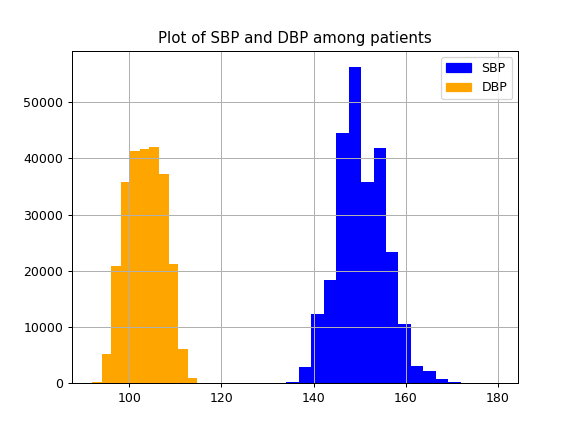

In [18]:
% matplotlib notebook
bp_medication_df.sbp.hist(bins=30, color='blue')
bp_medication_df.dbp.hist(bins=30, color='orange')
plt.title("Plot of SBP and DBP among patients")
blue_patch = mpatches.Patch(color='blue', label='SBP')
oragne_patch = mpatches.Patch(color='orange', label='DBP')
plt.legend(handles=[blue_patch, oragne_patch])
plt.show()

<IPython.core.display.Javascript object>


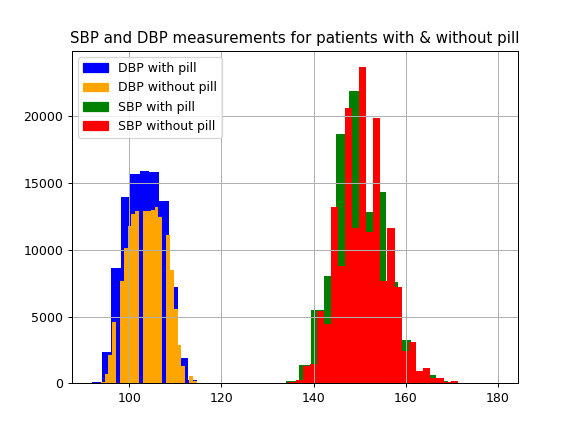

In [17]:
% matplotlib notebook
bp_medication_df[bp_medication_df.pill_detect == True].sbp.hist(bins=30, color='green')
bp_medication_df[bp_medication_df.pill_detect == False].sbp.hist(bins=30, color='red')
bp_medication_df[bp_medication_df.pill_detect == True].dbp.hist(bins=30, color='blue')
bp_medication_df[bp_medication_df.pill_detect == False].dbp.hist(bins=30, color='orange')

blue_patch = mpatches.Patch(color='blue', label='DBP with pill')
oragne_patch = mpatches.Patch(color='orange', label='DBP without pill')
green_patch = mpatches.Patch(color='green', label='SBP with pill')
red_patch = mpatches.Patch(color='red', label='SBP without pill')
plt.legend(handles=[blue_patch, oragne_patch, green_patch, red_patch])
plt.title('SBP and DBP measurements for patients with & without pill')
plt.show()

Data holds the normality assumption and a shift in the gaussian is noticed in both sbp & dbp when the patients are not pill.

In [8]:
pilldetect_true = bp_medication_df[bp_medication_df.pill_detect == True].groupby(
    'user_id', as_index=False)['sbp', 'dbp'].mean()
pilldetect_false = bp_medication_df[bp_medication_df.pill_detect == False].groupby(
    'user_id', as_index=False)['sbp', 'dbp'].mean()
sbp_dbp_means = pilldetect_false.merge(pilldetect_true, on='user_id', suffixes=('_no_pill', '_taken_pill'))
display(sbp_dbp_means.head())
display(sbp_dbp_means.describe())

,user_id,sbp_no_pill,dbp_no_pill,sbp_taken_pill,dbp_taken_pill
0,100000,154.043478,104.782609,153.750000,106.416667
1,100002,144.564103,102.333333,143.388889,102.833333
2,100003,140.971429,100.828571,141.210526,100.315789
3,100006,150.256410,104.205128,150.055556,102.444444
4,100007,152.054054,104.216216,151.052632,104.368421


,user_id,sbp_no_pill,dbp_no_pill,sbp_taken_pill,dbp_taken_pill
count,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000
mean,102205.209153,150.501396,103.669229,150.041041,103.508420
std,1272.116133,4.891933,1.746519,4.876321,1.827979
min,100000.000000,136.567568,98.062500,135.969697,97.571429
25%,101104.250000,147.118723,102.472222,146.714286,102.238095
50%,102201.500000,150.333333,103.606061,149.769231,103.428571
75%,103305.750000,153.547078,104.779810,153.071429,104.695652
max,104409.000000,171.897436,111.333333,171.285714,111.300000


## Significance testing
    variances are almost same --> 2 sided 2 sample T-test. 
    If looking for just one-sided p-value then divide the p-value by 2

#### T - test Assumptions
    1. Continous measurements (satisified)
    2. Random subset of population (my assumption)
    3. Data follows approximately normal distribution (satisified. see above graphs)
    4. Reason large sample (4000 samples is a decent sample size)
    5. Homogeneity of variance (Satisfied see std in the describe method on the dataframe above)

In [9]:
print("2 sample T-test for sbp: ", ttest_ind(sbp_dbp_means.sbp_no_pill, sbp_dbp_means.sbp_taken_pill))
print("2 sample T-test for dbp: ", ttest_ind(sbp_dbp_means.dbp_no_pill, sbp_dbp_means.dbp_taken_pill))

2 sample T-test for sbp:  Ttest_indResult(statistic=4.4058631817251515, pvalue=1.0661989777765571e-05)
2 sample T-test for dbp:  Ttest_indResult(statistic=4.2047234590195437, pvalue=2.6400809366679859e-05)


Low p-value and a positive test statistic(a=no_pill, b=taken_pill) in the tests for both sbp and dbp impily that skipping medication increases the risk of having a high sbp/dbp. 

## Question 2

In [12]:
bp_medication_df.head()

,user_id,date,sbp,dbp,pill_detect,mid_date,is_month1,is_month2,next_date,follow_up_gap
0,100000,2017-04-24,153.0,108.0,False,2017-05-23,True,False,2017-04-25,1 days
1,100000,2017-04-25,152.0,106.0,True,2017-05-23,True,False,2017-04-26,1 days
2,100000,2017-04-26,151.0,106.0,True,2017-05-23,True,False,2017-04-27,1 days
3,100000,2017-04-27,154.0,109.0,False,2017-05-23,True,False,2017-04-28,1 days
4,100000,2017-04-28,155.0,100.0,False,2017-05-23,True,False,2017-04-29,1 days


In [13]:
first_month = bp_medication_df[bp_medication_df.is_month1 == True][['user_id', 'is_month1', 'pill_detect']]
first_month_pills_taken = first_month[
    first_month.pill_detect == True][['user_id', 'is_month1']].groupby('user_id', as_index=False).count()
first_month_days_recorded = first_month[['user_id', 'is_month1']].groupby('user_id', as_index=False).count()

second_month = bp_medication_df[bp_medication_df.is_month2 == True][['user_id', 'is_month2', 'pill_detect']]
second_month_pills_taken = second_month[
    second_month.pill_detect == True][['user_id', 'is_month2']].groupby('user_id', as_index=False).count()
second_month_days_recorded = second_month[['user_id', 'is_month2']].groupby('user_id', as_index=False).count()

# rename columns
first_month_pills_taken.columns = ['user_id', 'first_month_pills_taken']
first_month_days_recorded.columns = ['user_id', 'first_month_days_recorded']

second_month_pills_taken.columns = ['user_id', 'second_month_pills_taken']
second_month_days_recorded.columns = ['user_id', 'second_month_days_recorded']

monthly_medication_df = first_month_pills_taken.merge(first_month_days_recorded, on='user_id').merge(
    second_month_pills_taken, on='user_id').merge(second_month_days_recorded, on='user_id')

monthly_medication_df['first_month_adherence'] = monthly_medication_df[
    'first_month_pills_taken']/monthly_medication_df['first_month_days_recorded']
monthly_medication_df['second_month_adherence'] = monthly_medication_df[
    'second_month_pills_taken']/monthly_medication_df['second_month_days_recorded']
monthly_medication_df.head()

,user_id,first_month_pills_taken,first_month_days_recorded,second_month_pills_taken,second_month_days_recorded,first_month_adherence,second_month_adherence
0,100000,5,29,7,29,0.172414,0.241379
1,100002,6,27,12,30,0.222222,0.400000
2,100003,12,25,7,29,0.480000,0.241379
3,100006,10,28,8,29,0.357143,0.275862
4,100007,8,29,11,27,0.275862,0.407407


In [17]:
display(monthly_medication_df.describe())

,user_id,first_month_pills_taken,first_month_days_recorded,second_month_pills_taken,second_month_days_recorded,first_month_adherence,second_month_adherence
count,4341.000000,4341.000000,4341.000000,4341.000000,4341.000000,4341.000000,4341.000000
mean,102205.897489,8.331490,28.007832,13.593872,29.856254,0.297394,0.455459
std,1272.044729,5.098025,1.018462,6.230315,1.088302,0.181384,0.208466
min,100000.000000,1.000000,23.000000,1.000000,24.000000,0.034483,0.032258
25%,101105.000000,5.000000,27.000000,9.000000,29.000000,0.172414,0.290323
50%,102203.000000,7.000000,28.000000,13.000000,30.000000,0.259259,0.433333
75%,103305.000000,11.000000,29.000000,18.000000,31.000000,0.392857,0.612903
max,104409.000000,28.000000,29.000000,30.000000,31.000000,0.965517,1.000000


## Significance test for adherence improvement

    variances are almost same for each month adherence --> 2 sided 2 sample T-test. 

In [14]:
ttest_ind(monthly_medication_df.first_month_adherence, monthly_medication_df.second_month_adherence)

Ttest_indResult(statistic=-37.687855129809392, pvalue=5.1203780035829671e-288)

low p-value indicates that both the samples are not similar 

negative test statistic (a=first_month_adherence, b=second_month_adherence) indicates that overall people had more adherence in the second month

In [15]:
monthly_medication_df.first_month_adherence.mean()

0.2973943520389648

In [16]:
monthly_medication_df.second_month_adherence.mean()

0.45545887585809464

We can further analyze the patients in depth by classfying them into classes (overweight, obese1, obese2, obese3) or into categories (normal, pre-hypertension, high).

I enjoyed working on this task, Thank You!

Veera Marni

narayana1043@gmail.com